In [194]:
import pandas_datareader as pdr
import pandas as pd

In [195]:
# pip install pandas
pd.__version__

'2.2.3'

In [196]:
# key = 'cba82d250fdf31bcb28e0911d44e34f1ab8f5546'
# data = pdr.get_data_tiingo('AAPL', api_key=key)

In [197]:
# import requests

# key = 'cba82d250fdf31bcb28e0911d44e34f1ab8f5546'
# url = f"https://api.tiingo.com/tiingo/daily/AAPL/prices?token={key}"
# response = requests.get(url)
# data = response.json()

In [198]:
import yfinance as yf
df = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed


In [199]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.796036,72.856628,71.545402,71.799888,135480400
2020-01-03,72.088303,72.851769,71.862900,72.020439,146322800
2020-01-06,72.662712,72.701492,70.954002,71.206070,118387200
2020-01-07,72.320984,72.929329,72.100426,72.672417,108872000
2020-01-08,73.484360,73.787323,72.022865,72.022865,132079200


In [200]:
df2 = df.reset_index()['Close']

In [201]:
df2

Ticker,AAPL
0,72.796036
1,72.088303
2,72.662712
3,72.320984
4,73.484360
...,...
1001,192.656174
1002,192.108856
1003,192.208374
1004,192.636292


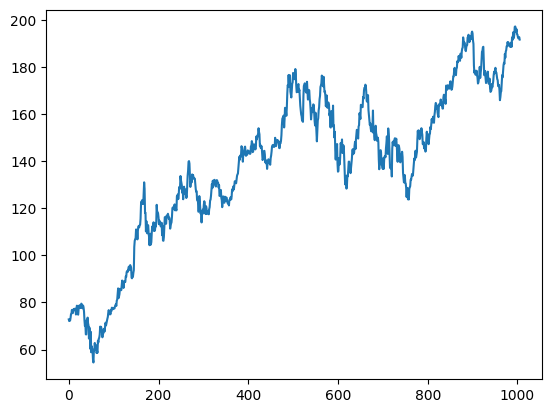

In [202]:
import matplotlib.pyplot as plt
plt.plot(df2)

In [203]:
# LSTM are sensitive to scale of data, apply min-max scalar

In [204]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [205]:
df2.shape

(1006, 1)

In [206]:
df2

array([[0.12820387],
       [0.123242  ],
       [0.12726914],
       ...,
       [0.96539541],
       [0.96839551],
       [0.96106963]])

In [207]:
train_size = int(len(df2)*0.65)
test_size = len(df2) - train_size
train_data, test_data = df2[0:train_size,:], df2[train_size:len(df2),:1]

In [208]:
train_size, test_size, len(df)

(653, 353, 1006)

In [209]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [210]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [211]:
X_train.shape, X_test.shape

((552, 100), (252, 100))

In [212]:
y_train.shape, y_test.shape

((552,), (252,))

In [213]:
# reshape input to be [samples, timesteps, features] required for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [215]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True)) # return sequences - full sequence of outputs for each time step
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\dell\anaconda3\envs\dl\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [216]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [217]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64,verbose=2)

Epoch 1/100
9/9 - 31s - 3s/step - loss: 0.1054 - val_loss: 0.0062
Epoch 2/100
9/9 - 4s - 419ms/step - loss: 0.0123 - val_loss: 0.0288
Epoch 3/100
9/9 - 3s - 330ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 4/100
9/9 - 3s - 316ms/step - loss: 0.0043 - val_loss: 0.0144
Epoch 5/100
9/9 - 3s - 316ms/step - loss: 0.0039 - val_loss: 0.0073
Epoch 6/100
9/9 - 3s - 307ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 7/100
9/9 - 3s - 305ms/step - loss: 0.0027 - val_loss: 0.0074
Epoch 8/100
9/9 - 3s - 289ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 9/100
9/9 - 3s - 332ms/step - loss: 0.0023 - val_loss: 0.0068
Epoch 10/100
9/9 - 3s - 316ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 11/100
9/9 - 3s - 339ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 12/100
9/9 - 5s - 552ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 13/100
9/9 - 3s - 320ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 14/100
9/9 - 3s - 303ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 15/100
9/9 - 3s - 325ms/step - loss: 0.

In [218]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step 


In [219]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [220]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

136.1349552128728

In [221]:
math.sqrt(mean_squared_error(y_test, test_predict))

169.85487487930052

In [222]:
len(test_data)

353

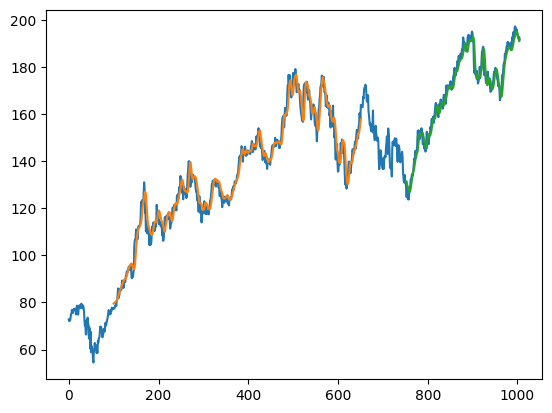

In [223]:
lookback = 100 # used as previous timestep and moved and added at last
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, :] = train_predict # first 100 were used to predict

# shift test prediction for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(df2)-1,:] = test_predict # to get the test starting point and plot from on

#baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [224]:
# predict for next 30 days

In [225]:
len(test_data)

353

In [226]:
# 353 to find the next one(354) we have to take previous 100 data
X_input = test_data[253:].reshape(1,-1)
X_input

array([[0.85771308, 0.85618254, 0.85660051, 0.86823632, 0.85423137,
        0.84810001, 0.83019345, 0.83360766, 0.84301362, 0.85269858,
        0.8798025 , 0.84677626, 0.8623139 , 0.87332271, 0.90070509,
        0.92530058, 0.92683369, 0.93791193, 0.93958422, 0.89227435,
        0.85499797, 0.85931776, 0.86753957, 0.8462188 , 0.8316567 ,
        0.84231698, 0.83723048, 0.85785461, 0.86551907, 0.84057516,
        0.82970563, 0.8356978 , 0.84468591, 0.81597956, 0.80531907,
        0.80713064, 0.81075389, 0.82845152, 0.81904524, 0.82782441,
        0.83653395, 0.85451026, 0.86496172, 0.86078101, 0.87060536,
        0.87694586, 0.86398629, 0.86308029, 0.85214112, 0.84301362,
        0.84036602, 0.82238981, 0.82322585, 0.82629152, 0.80998749,
        0.78065394, 0.78992083, 0.80434364, 0.80768821, 0.82998431,
        0.85506762, 0.84865737, 0.86663379, 0.88467996, 0.89213517,
        0.88879071, 0.91830228, 0.90713941, 0.92555808, 0.92953478,
        0.94139536, 0.94125586, 0.95353483, 0.94

In [227]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [228]:
X_input = X_input.reshape(1,100,1)
yhat = model.predict(X_input, verbose=0)
yhat,yhat[0].tolist()

(array([[0.9529394]], dtype=float32), [0.9529393911361694])

In [229]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        print('\n--------------------------------------------')
        X_input=X_input.reshape(1,-1)
        X_input = X_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(X_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        X_input = X_input.reshape((1, n_steps,1)) # model accepts batches so reshaped
        yhat = model.predict(X_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9529394]
101
1 day input [0.85618254 0.85660051 0.86823632 0.85423137 0.84810001 0.83019345
 0.83360766 0.84301362 0.85269858 0.8798025  0.84677626 0.8623139
 0.87332271 0.90070509 0.92530058 0.92683369 0.93791193 0.93958422
 0.89227435 0.85499797 0.85931776 0.86753957 0.8462188  0.8316567
 0.84231698 0.83723048 0.85785461 0.86551907 0.84057516 0.82970563
 0.8356978  0.84468591 0.81597956 0.80531907 0.80713064 0.81075389
 0.82845152 0.81904524 0.82782441 0.83653395 0.85451026 0.86496172
 0.86078101 0.87060536 0.87694586 0.86398629 0.86308029 0.85214112
 0.84301362 0.84036602 0.82238981 0.82322585 0.82629152 0.80998749
 0.78065394 0.78992083 0.80434364 0.80768821 0.82998431 0.85506762
 0.84865737 0.86663379 0.88467996 0.89213517 0.88879071 0.91830228
 0.90713941 0.92555808 0.92953478 0.94139536 0.94125586 0.95353483
 0.9478837  0.95255801 0.94320939 0.94195357 0.94620928 0.93902322
 0.94306968 0.95206987 0.93944194 0.96727908 0.95960467 0.97320932
 0.98325576 0.96560466 0.97627917 0.

In [230]:
day_new=np.arange(1,101) # 100 rows taken from test
day_pred=np.arange(101,131) # 30 rows to predict

In [231]:
len(df2)

1006

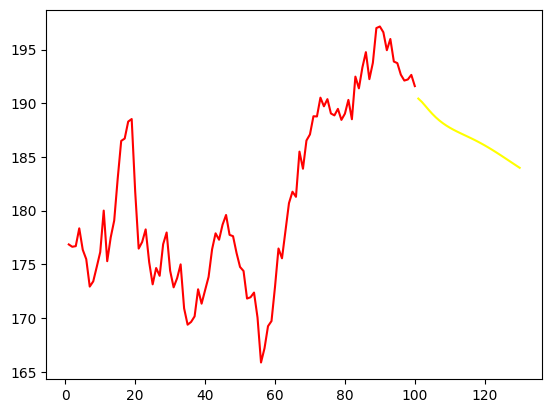

In [232]:
import matplotlib.pyplot as plt

plt.plot(day_new,scaler.inverse_transform(df2[906:]), color='red') # len(df2) - 100
plt.plot(day_pred,scaler.inverse_transform(lst_output), color='yellow')
plt.show()

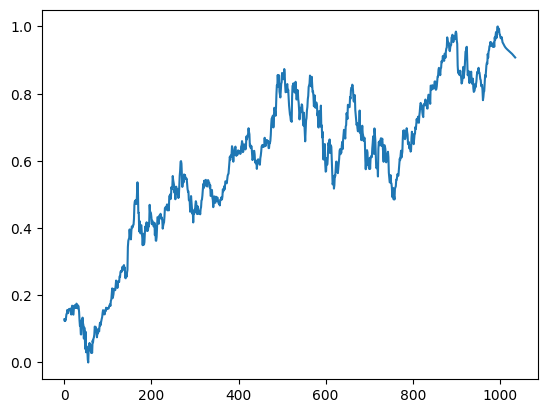

In [233]:
df3=df2.tolist()
df3.extend(lst_output)
# plt.plot(df3[800:])
plt.plot(df3)

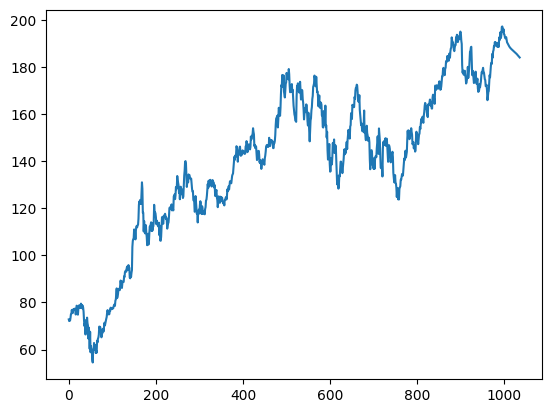

In [234]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)